### Building Chatbot With Multiple Tools Using LangGraph
Create a Chatbot with tool capablities from arxiv, wikipedia search and some functions

In [16]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
import os
from dotenv import load_dotenv
load_dotenv()

True

In [17]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=1000)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [18]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [19]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=5000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [20]:
wiki.invoke("Who is APJ Kalam")

'Page: A. P. J. Abdul Kalam\nSummary: Avul Pakir Jainulabdeen Abdul Kalam (  UB-duul kə-LAHM; 15 October 1931 – 27 July 2015) was an Indian aerospace scientist and statesman who served as the  president of India from 2002 to 2007.\nBorn and raised in a Muslim family in Rameswaram, Tamil Nadu, Kalam studied physics and aerospace engineering. He spent the next four decades as a scientist and science administrator, mainly at the Defence Research and Development Organisation (DRDO) and Indian Space Research Organisation (ISRO) and was intimately involved in India\'s civilian space programme and military missile development efforts. He was known as the "Missile Man of India" for his work on the development of ballistic missile and launch vehicle technology. He also played a pivotal organisational, technical, and political role in Pokhran-II nuclear tests in 1998, India\'s second such test after the first test in 1974.\nKalam was elected as the president of India in 2002 with the support of 

#### Tavily Search Tool from langchain
Create an API key to use Tavily Search

In [21]:
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

In [22]:
from langchain_community.tools import TavilySearchResults

tavily = TavilySearchResults()

tavily.invoke("Latest news on Bengaluru rains")

[{'title': 'DK Shivakumar meets families of two who died by electrocution',
  'url': 'https://www.hindustantimes.com/cities/bengaluru-news/bengaluru-weather-live-updates-bangalore-rain-imd-red-yellow-alert-forecast-today-101747710222974.html',
  'content': 'Bengaluru rain | Key updates Amid intense rain in Bengaluru, BJP MP PC Mohan requested companies in the city, including Infosys, to consider work-from-home arrangements for employees to help reduce the impact on employees and business in India\'s "Silicon Valley".Karnataka deputy chief minister DK Shivakumar, meanwhile, said that the Bruhat Bengaluru Mahanagara Palike (BBMP) has fixed 70 per cent of the 210 flood-prone areas identified in the city, adding that the work on the remaining 30 per [...] Bengaluru weather live updates: The Regional Meteorological Centre in Bengaluru has issued warnings for coastal Karnataka. It predicts extremely heavy rain, thunderstorms, and lightning with strong surface winds until May 21 and very heav

Combine all the tools in the list

In [23]:
tools = [arxiv, wiki, tavily]

In [24]:
from langchain_groq import ChatGroq

llm = ChatGroq(api_key=groq_api_key, model='qwen-qwq-32b')

llm_with_tools = llm.bind_tools(tools)

In [25]:
from langchain_core.messages import AIMessage, HumanMessage

#lets see below which tool does the llm call
result = llm_with_tools.invoke([HumanMessage(content="What is recent new in Agentic AI?")])

In [26]:
result.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Recent advancements in Agentic AI 2023'},
  'id': 'call_p235',
  'type': 'tool_call'}]

### Lets build the Chatbot using LangGraph

In [27]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

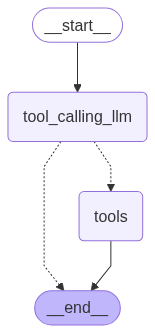

In [34]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


In [44]:
tools=[arxiv,wiki,tavily,add,multiply,divide]
llm = ChatGroq(api_key=groq_api_key, model='qwen-qwq-32b')
llm_with_tools = llm.bind_tools(tools)

In [53]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

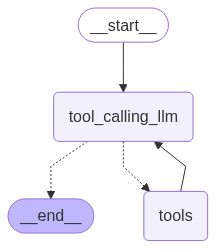

In [54]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

def tool_calling_llm(state:State):
    return {
        "messages": [llm_with_tools.invoke(state['messages'])]
    }

builder = StateGraph(State)

builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition)
builder.add_edge('tools', "tool_calling_llm")
#  NOTE: here there is no END edge as this is ReAct Architecture

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 5 recent AI news. what is 5 plus 5? Multiply the result by 5 and divide the result by 2")})
messages

{'messages': [HumanMessage(content='Provide me the top 5 recent AI news. what is 5 plus 5? Multiply the result by 5 and divide the result by 2', additional_kwargs={}, response_metadata={}, id='975114a1-b760-4bac-9e79-fdcfba1616fd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6q6v', 'function': {'arguments': '{"query": "top 5 recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_fqad', 'function': {'arguments': '{"a": 5, "b": 5}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_sytc', 'function': {'arguments': '{"a": 10, "b": 5}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_w87n', 'function': {'arguments': '{"a": 50, "b": 2}', 'name': 'divide'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 324, 'prompt_tokens': 664, 'total_tokens': 988, 'completion_time': 0.791385097, 'prompt_time': 0.038813798, 'queue_time': 0.247098272, 'total_time': 0.830198895}, 'model_name': 'qwen-qwq-32

In [69]:
result = llm_with_tools.invoke([HumanMessage(content="Provide me the top 5 recent AI news. what is 5 plus 5? Multiply the result by 5 and divide the result by 2")])
result.tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'top 5 recent AI news'},
  'id': 'call_d5mv',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 5, 'b': 5},
  'id': 'call_2khc',
  'type': 'tool_call'},
 {'name': 'multiply',
  'args': {'a': 10, 'b': 5},
  'id': 'call_anq7',
  'type': 'tool_call'},
 {'name': 'divide',
  'args': {'a': 50, 'b': 2},
  'id': 'call_j90a',
  'type': 'tool_call'}]

In [62]:
# Extract and print the last AIMessage content
from langchain_core.messages import AIMessage

for msg in reversed(messages["messages"]):
    if isinstance(msg, AIMessage):
        print(msg.content)
        break

Here's the information based on the tool responses:

**Top 5 Recent AI News (4 entries found):**  
1. **Meta's AI Defamation Lawsuit (April 30, 2025):**  
   - Robby Starbuck sues Meta for $5M over false claims made by its AI chatbot about his involvement in the 2021 Capitol riot and QAnon ties.  
   - Highlights risks of AI-generated misinformation.  

2. **China's AI Acceleration (March 12, 2025):**  
   - China is advancing AI development to counter U.S. trade restrictions, launching models like Manus and DeepSeek, and building a National Computing Power Grid.  

3. **Larry Page's AI Startup (March 7, 2025):**  
   - Google co-founder Larry Page launches Dynatomics, a new AI-focused startup.  

4. **Apple's AI Updates (May 2, 2025):**  
   - Apple introduced AI-driven features like advanced photo editing, predictive text, and health tools in its ecosystem.  

*(Note: Only 4 results were returned.)*  

**Math Calculation:**  
- **5 + 5 = 10**  
- **10 × 5 = 50**  
- **50 ÷ 2 = 25**  

### Agents with Memory Saver
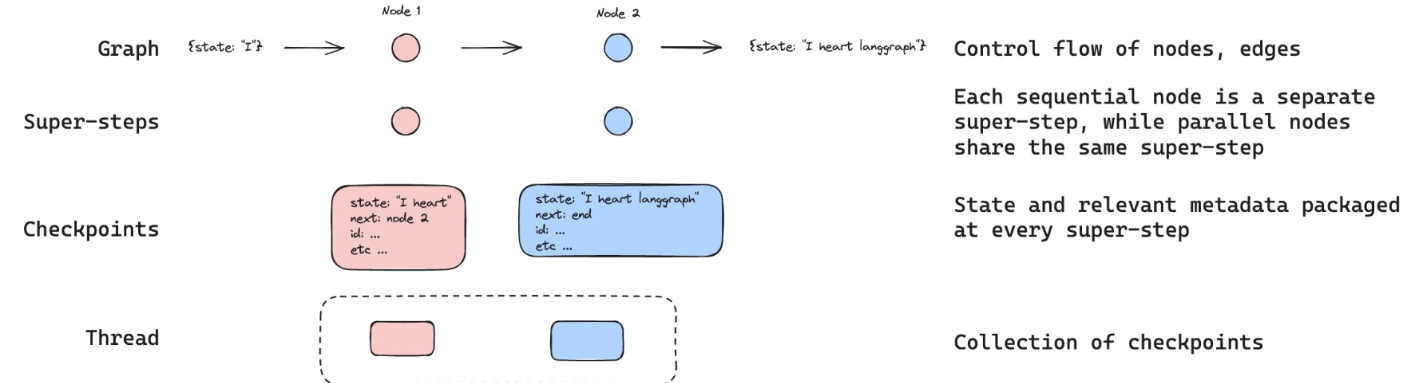

In [70]:
from langchain_openai import ChatOpenAI
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools(tools)

In [72]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

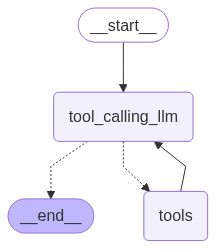

In [73]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)
# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [74]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_5HuST3DDDUUNwVhvyzEjj47A)
 Call ID: call_5HuST3DDDUUNwVhvyzEjj47A
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.


In [75]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_5HuST3DDDUUNwVhvyzEjj47A)
 Call ID: call_5HuST3DDDUUNwVhvyzEjj47A
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_28aYwMBnOFqWw9XfBL3HU79L)
 Call ID: call_28aYwMBnOFqWw9XfBL3HU79L
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 2

In [76]:
messages = [HumanMessage(content="then multiplty that number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_5HuST3DDDUUNwVhvyzEjj47A)
 Call ID: call_5HuST3DDDUUNwVhvyzEjj47A
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_28aYwMBnOFqWw9XfBL3HU79L)
 Call ID: call_28aYwMBnOFqWw9XfBL3HU79L
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 2